# EDA for "Pump it Up: Data Mining the Water Table"

### Data Modelling & Analysis CW2

**Predicting the status of wells in Tanzania using "Pump it Up: Data Mining the Water Table"**

Jason & Tom

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../datasets/train_features_water.csv')
df_labels = pd.read_csv('../datasets/train_labels_water.csv')
df = df.merge(df_labels, on='id', how='left')

## Explore the data

Checking for nulls, distributions and duplicates.

In [3]:
df.shape

(59400, 41)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]

null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


**Additional Columns**

     - Broader Region (N, S, W, E, NW, ...)
     - We should also maybe bin the construction years (every 2-5 years maybe)
     - Perhaps look into amount_tsh, see if we can do something with that...
    

    - scheme_name has too many missing values to be useful, we should drop this column.
    - scheme_management - this is a useful column so we shouldn't drop it, we could either replace all missing values with 'Other', (as we will likely have to do that anyway)
    - installer - same as scheme_management
    - funder - same as scheme_management
    - public_meeting - TODO: Find out what this column means....
    - permit - TODO: Find out what this column means...
    - subvillage we can impute based off other geographical data, perhaps using clustering.

In [6]:
df.nunique(axis=0)

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [7]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


amount_tsh (total vertical distance pump carries the water from source to tap (m))

    - max value of 350000 seems excessively high, we should look into that
    - especially when the max gps height is only 2770m (gps height is height of pump from sea-level).
   

population

    - why is min & 25% = 0, what does this mean - is this an error or is there actually no people in these areas

construction_year

    - a lot of 0 values, we will definitely need to impute this, perhaps based off waterpoint type/district rather than the mean (although we can try both).

In [8]:
# percent of data that has construction year 0

df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0]

0.34863636363636363

**Testing out the correlation between 'construction_year' and other features**

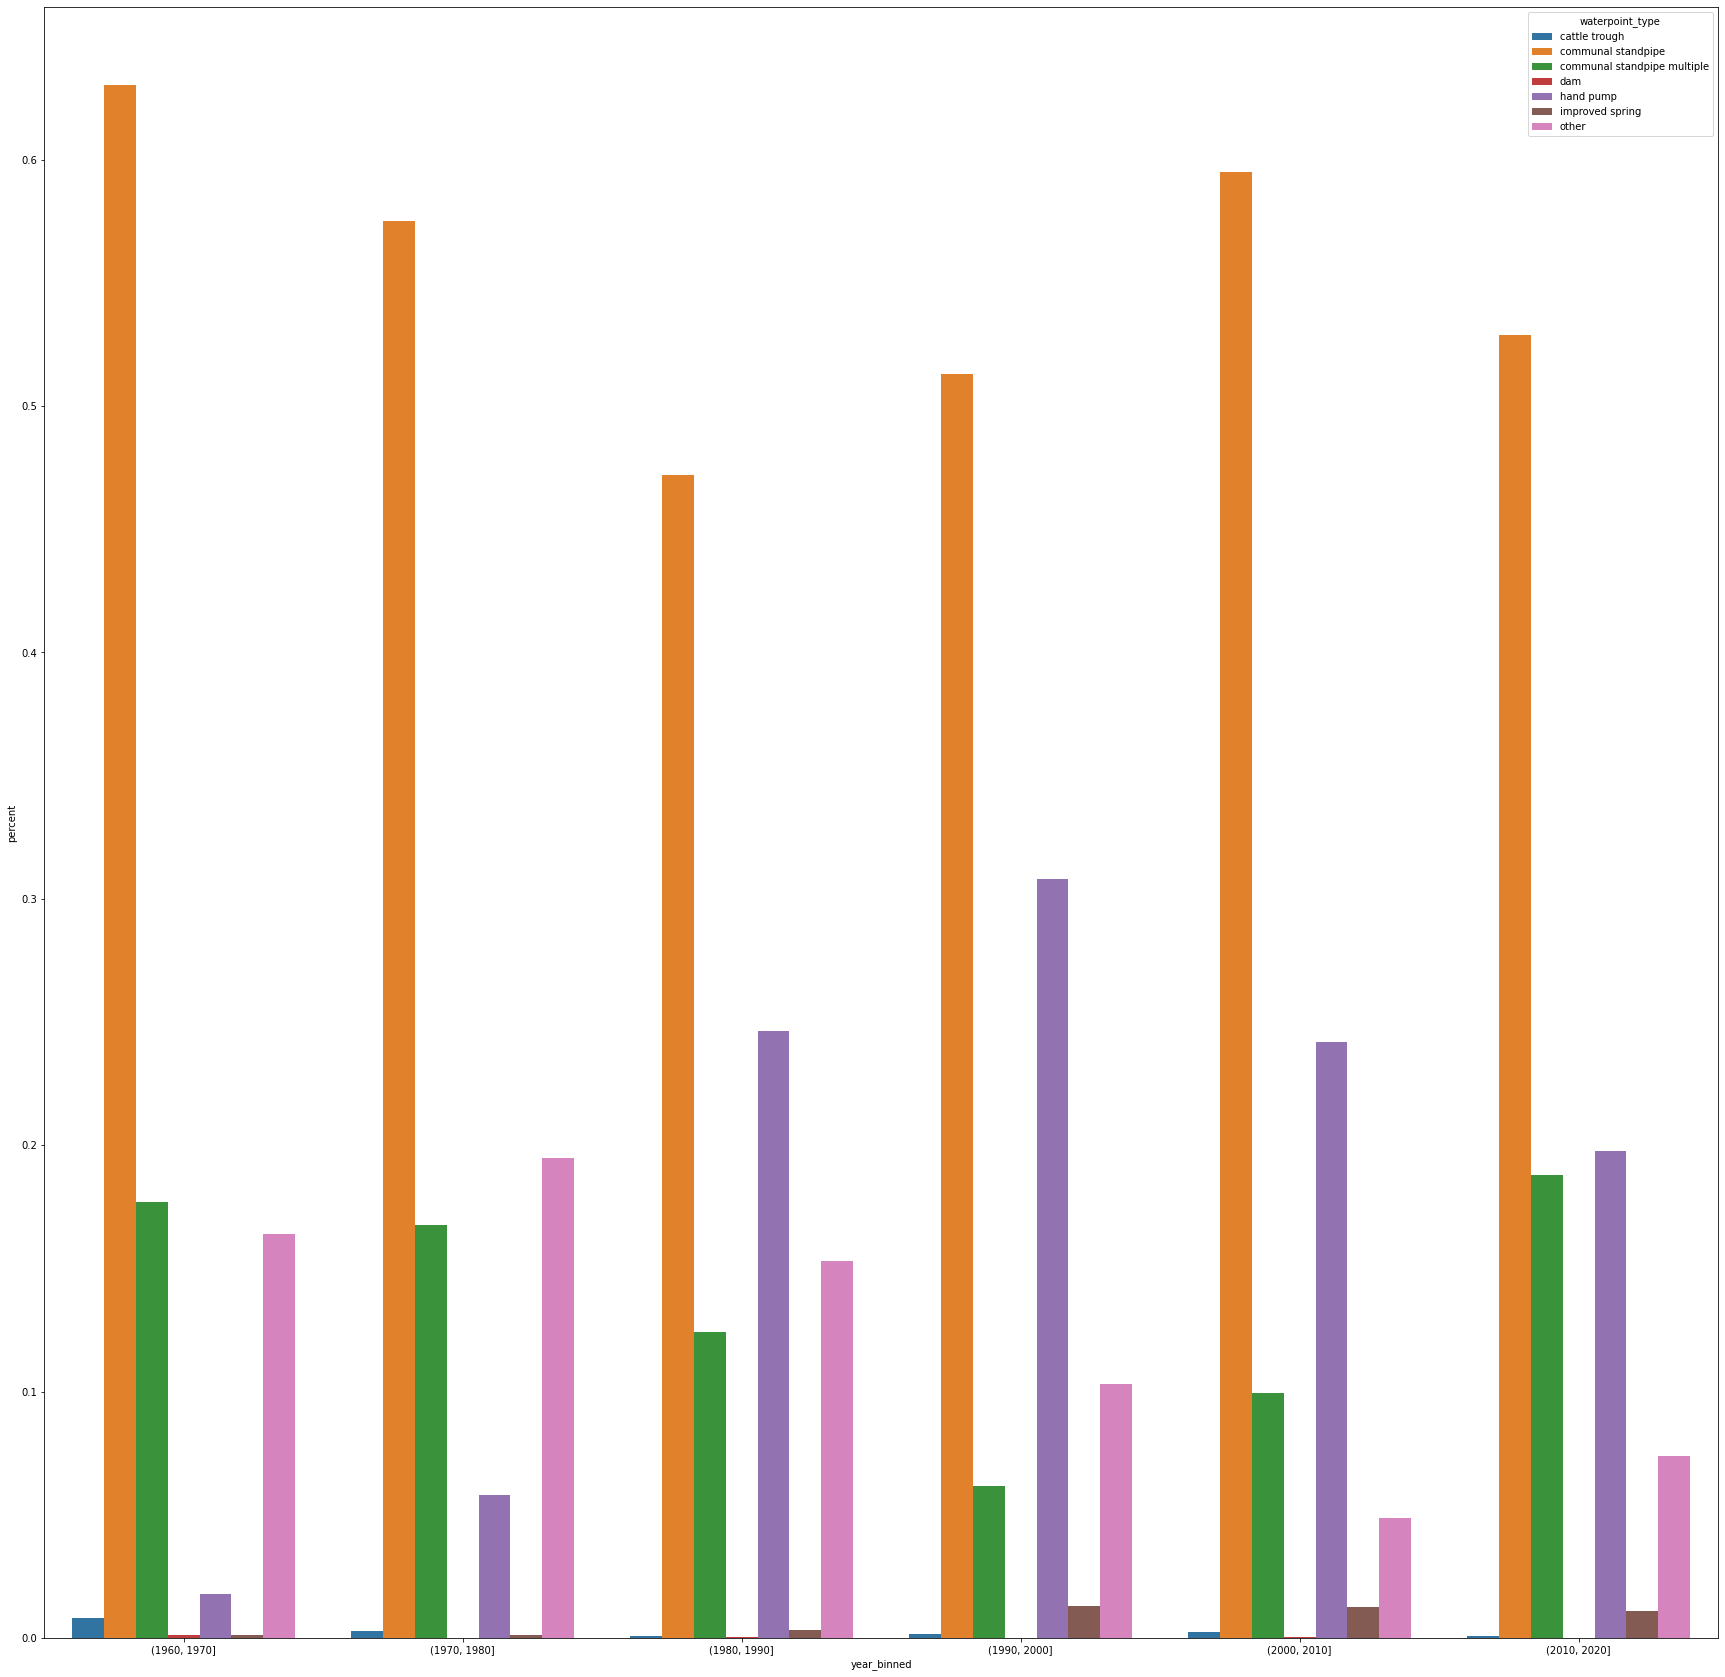

In [9]:
# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

There doesn't seem to be much correlation between the waterpoint_type and construction year. There are two points:

    - 'other' usage goes down as time progresses
    - 'hand pump' usage goes up as time progresses

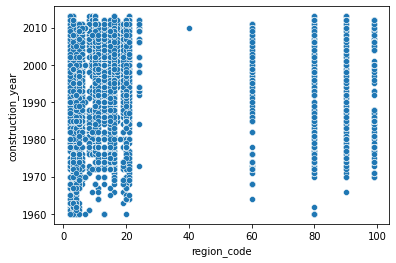

In [10]:
# We need to look some other correlations

sns.scatterplot(df_test, x='region_code', y='construction_year')
plt.show()

No correlation between construction_year and region

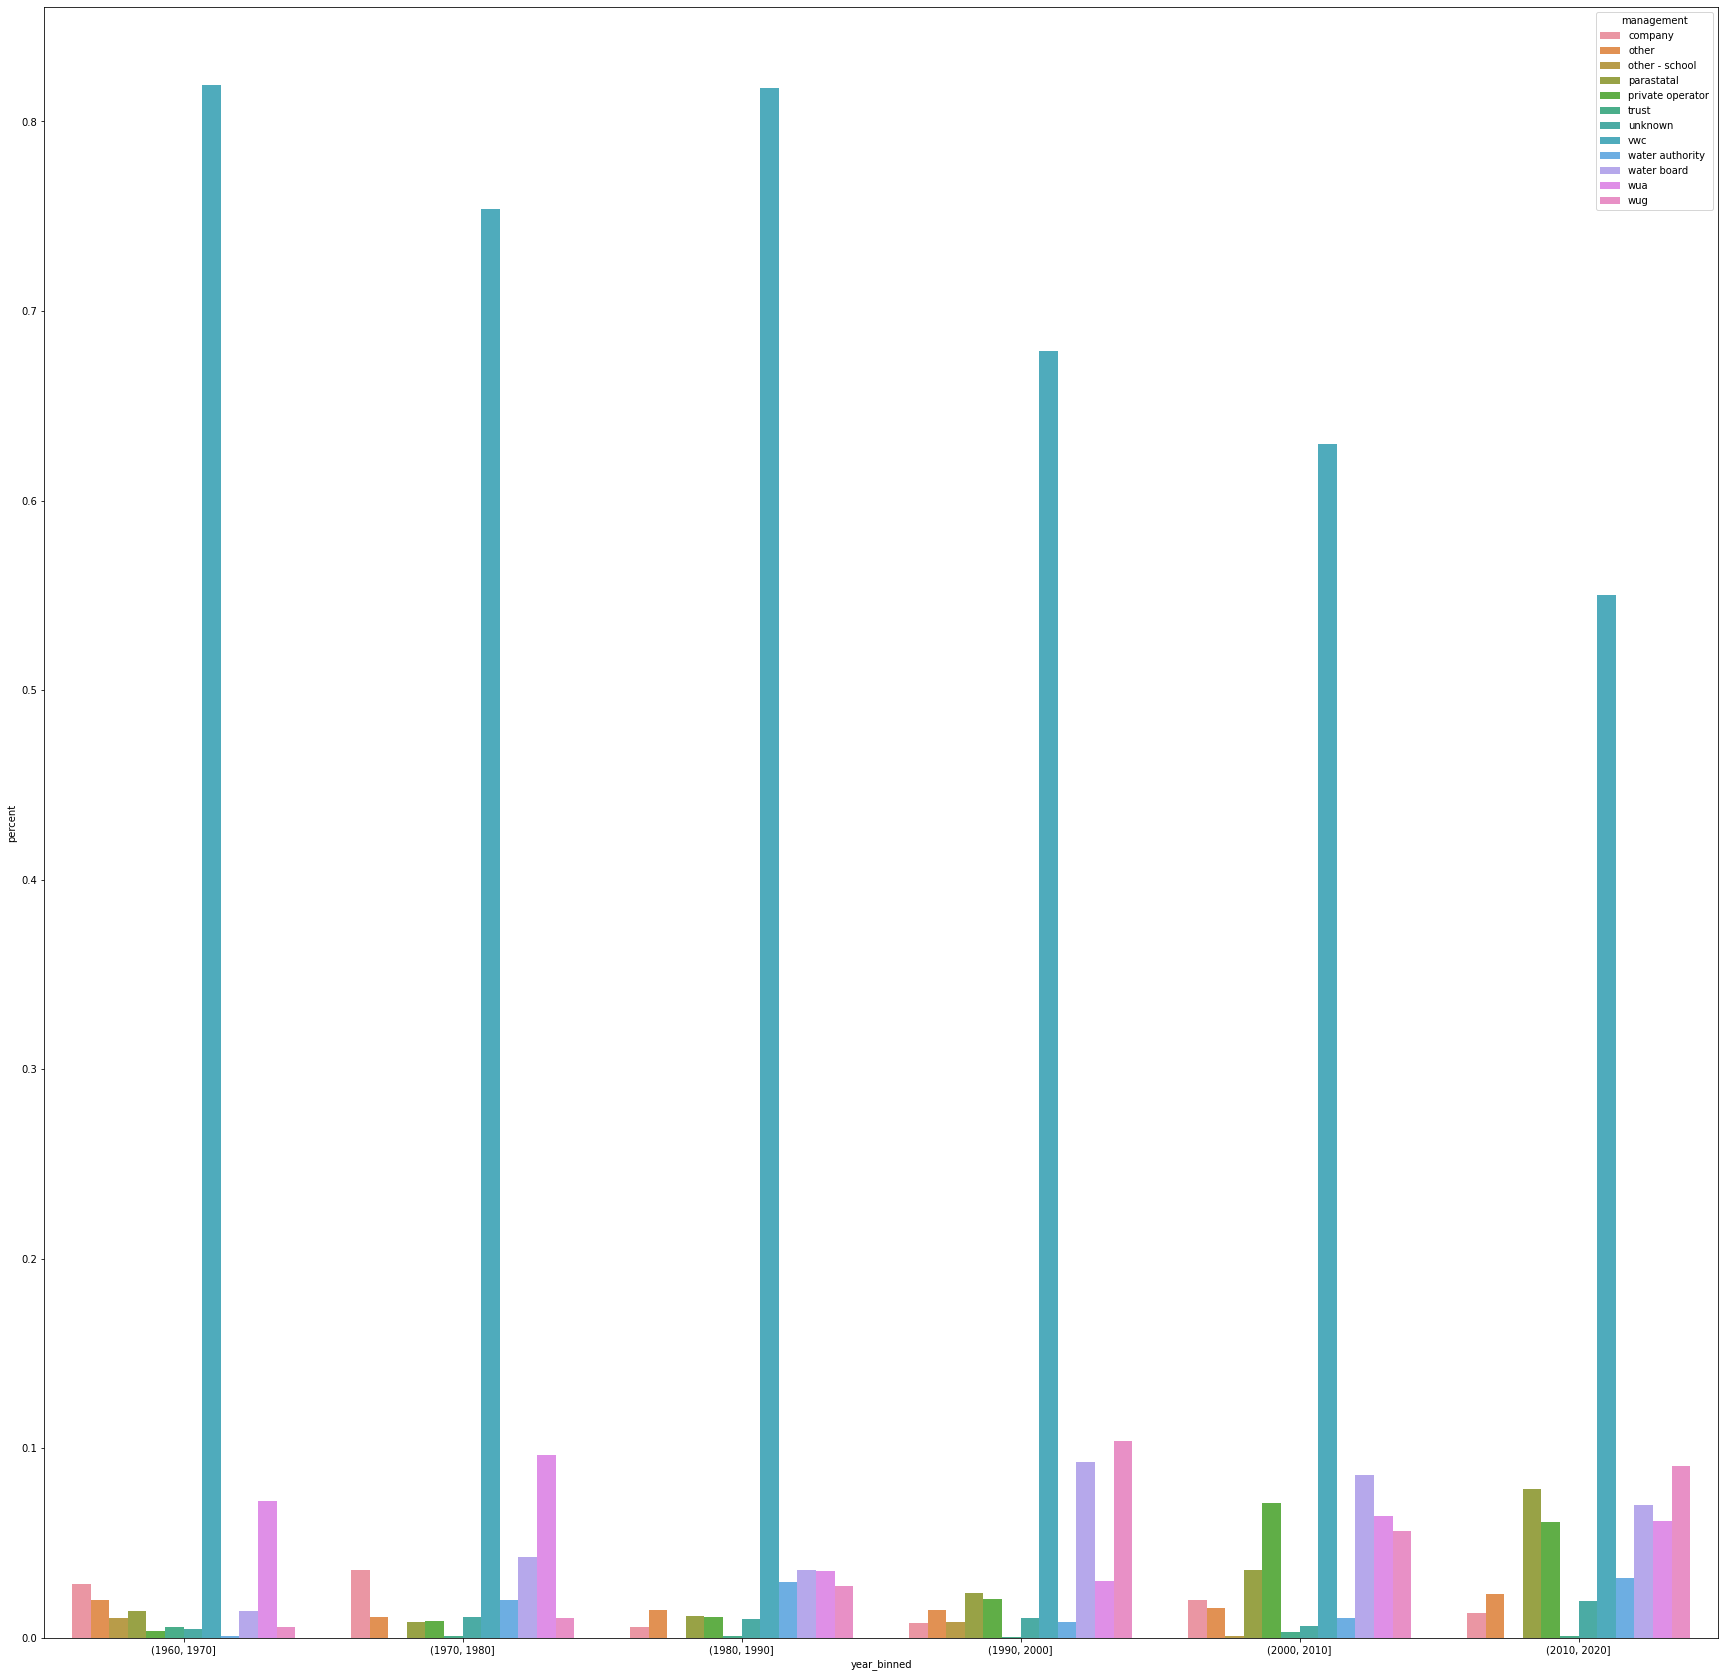

In [11]:
df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

Interesting point here, 'parastatal' and 'private' definitely go up in percentage installed as the years increase.

In [12]:
df_years = df_test.groupby('construction_year').size().reset_index(name='count')

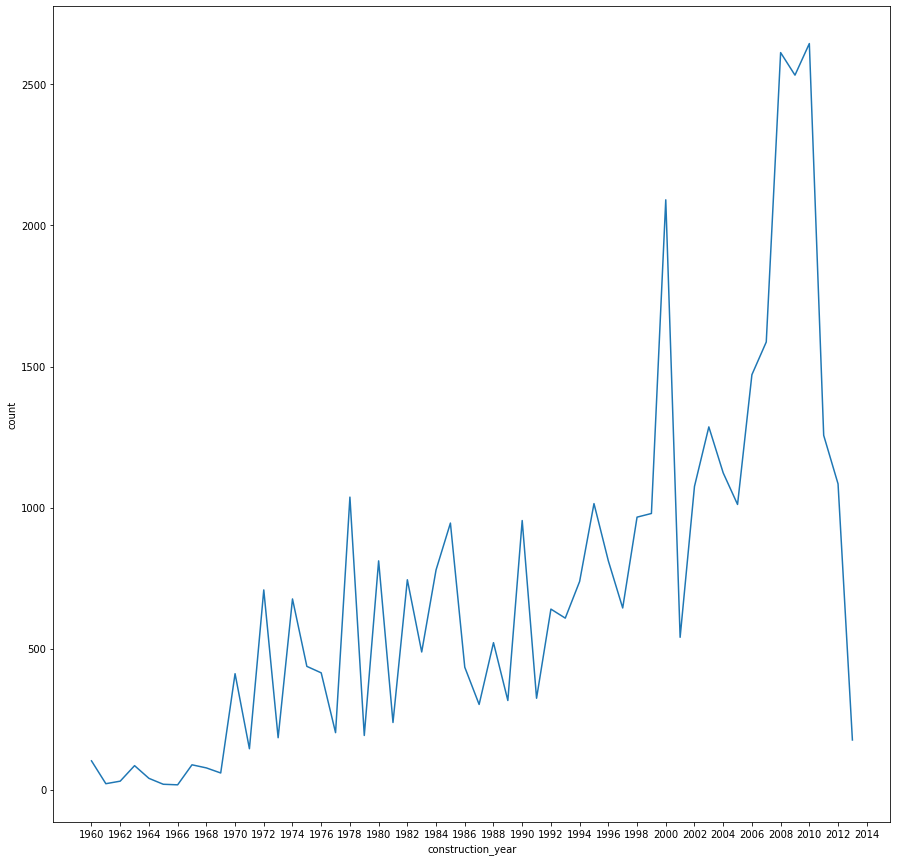

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

We could sample from this distribution? https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sample.html

mice: https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html

Here are also some useful imputers from scikit-learn https://scikit-learn.org/stable/modules/impute.html

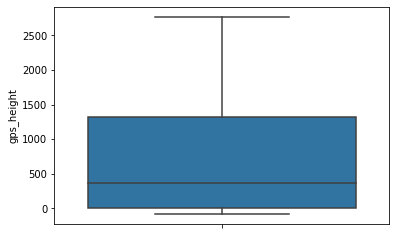

In [14]:
sns.boxplot(data=df, y='gps_height')
plt.show()

### Imputing 'missing' lat/lon data based off region

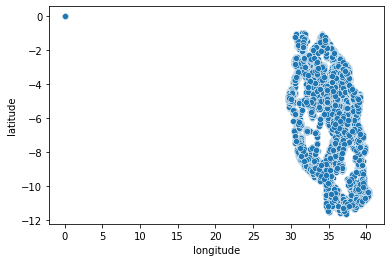

In [15]:
sns.scatterplot(df, x='longitude', y='latitude')
plt.show()

In [16]:
df['longitude'].replace(0, np.nan, inplace=True)
df['longitude'] = df['longitude'].fillna(df.groupby('region')['longitude'].transform('mean'))
df.loc[df['latitude'] == -2.000000e-08] = np.nan
df['latitude'] = df['latitude'].fillna(df.groupby('region')['latitude'].transform('mean'))

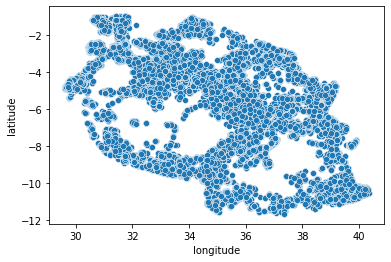

In [17]:
sns.scatterplot(df, x='longitude', y='latitude')
plt.show()

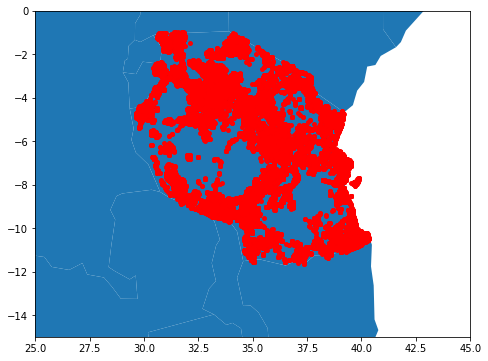

In [18]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', c="red", markersize=15);
ax.set_xlim(25, 45)
ax.set_ylim(-15, 0)
plt.show()


### Now let's drop un-needed columns

**Columns to drop**
    
    - id
    - scheme_name`
    - ward
    - subvillage
    - num_private
    - recorded_by
    - wpt_name
    - extraction_type
    - extraction_type_group
    - district_code
    - region_code
    - payment_type
    - quality_group
    - quantity_group
    - source
    - waterpoint_type_group
    
    - lga
    - ward

In [19]:
df.drop(['id', 'scheme_name', 'ward', 'subvillage', 'num_private',
              'recorded_by', 'wpt_name', 'extraction_type', 'extraction_type_group',
              'district_code', 'region_code', 'payment_type', 'quality_group',
             'quantity_group', 'source', 'waterpoint_type_group','lga'], axis=1, inplace=True)

### Encoding certain features to have less classes

The first one of these we tackle is the **funder** feature.

Some assumptions we make:

    - Any acronyms that are similar to a known acronym are classed as that acronym
        - 'Rwssp' is the known acronym; 'Rwsssp', 'Rssp', 'Wrssp' are all classed as 'Rwssp'
    - Some funder are just the water supply from which the water comes. These are classed as private companies
    - Schools & Universities are classed as local governments as they are often public schools, so the money comes from the council
    - DWE stands for District Water Engineer, however this is grouped with multiple parties such as NORAD (gov) or RCC (regilous). When DWE is on it's own it is local_gov, however what it is grouped with takes priority.
    - RWE (or regionwal WE) are government entities.

Anything that couldn't be found with a google search or intuition based on other values is left as unknown.

In [20]:
df['funder'].value_counts()

Government Of Tanzania    8842
Danida                    3114
Hesawa                    1914
World Bank                1345
Kkkt                      1287
                          ... 
Municipal Council            1
Afdp                         1
Comune Di Roma               1
Area                         1
Samlo                        1
Name: funder, Length: 1858, dtype: int64

These next cells are the full set of different values for each decided category.

In [202]:
foreign = ['Danida', 'Germany Republi','Netherlands', 'Norad','Jica', 'Jaica',
          'Nethalan', 'Swedish', 'Germany','China Government' 'Dwe/norad', 'Tz Japan',
          'European Union', 'Dads', 'Holland', 'Swiss If', 'Jika', 'Nethe', 'Dadis',
          'Norad/ Kidep', 'The People of Japan', 'Finland Government', 
          'A/co Germany', 'Us Embassy', 'Finland', 'Jeica', 'Aco/germany',  'Canada',
          'Belgian Government', 'People Of Japan', 'World Bank', 'British Colonial Government',
          'France', 'Gaica', 'U.S.A', 'Greec', 'Sweden', 'Japn Embassy',
          'Colonial Government', 'Japan Aid', 'Italy Government', 'Usa Embassy', 'China Government',
           'Watu Wa Ujerumani',  'Norad /government', 'Un', 'The People Of Japan', 'Eu/acra',
           'Ubalozi Wa Marekani', 'Franc', 'Comune Di Roma', 'Japan Food',  'Netherland', 'Korea', 'Japan Embassy',
           'Danida /government', 'World Bank/government', 'Unhcr/government', 'Norad/government', 'Japan Government', 'Irish Government',
           'Egypt Government',  'Iran Gover', 'Italy', 'British Tanza',  'People From Japan','Norad/ Tassaf Ii',
           'Niger', 'Morad', 'Sweeden', 'Dqnida', 'Holand', 'Norad/ Tassaf', 'Foreigne', 
           'Watu Wa Marekani', 'Italian', 'Natherland', 'Ubalozi Wa Japani', 'Japan  Food Aid Counter Part', 
           'Embasy Of Japan In Tanzania', 'People From Egypt', 'Daida', 'Nerthlands', 'Norad/rudep', 'Norad/japan', 'Netherla', 'People Of Sweden',
           'Canada Aid', 'Unhcr/danida', 'Danid', 'DANID', 'DA', 'Egypt Technical Co Operation', 'Eu',
           'Irish Ai', 'Friend From Un', 'Japan', 'Grobal resource alliance', 'Japan Food Aid', 'Ddca',
           'WOULD BANK', 'Belgiam Government', 'NORAD/', 'China', 'JAICA CO', 'AUSTRALIA', 'Belgij',
           'ITALI', 'DENISH', 'IRAN GOVERN', 'NIRAD', 'Word Bank', 'Britain', 'British government',
           'WORLD NK', 'Chinese', 'Wizra ya maji na egypt', 'Hilfe Fur Bruder', 'DANIDS', 'DANNIDA',
           'Italian government', 'GERMAN', 'Word bank', 'Tanz/Egypt technical coopera',
           'WORDL BANK',
          ]

In [201]:
gov = ['Government Of Tanzania', 'Rwssp', 'Ministry Of Water',  'Lga', 'Dwsp',
        'Rural Water Supply And Sanitat', 'Wsdp','Tanza', 'Kuwait', 'Finida German Tanzania Govt', 
       'Dwssp', 'Cipro/government', 'Water Board',  'Tanzania', 'Isf/government', 'Rwsp',
       'Government/ Community', 'Finidagermantanzania Govt', 'Government/ World Bank',  'Member of Parliament',
       'Government /tassaf',  'Rwsssp',  'Tassaf/ Danida', 'Rwssp/wsdp', 'Ministry of Education',
        'Rssp','Koica and Tanzania Government','Ministry of Water', 'Dhv', 'Water', 'Rudep', 'W.B',
       'Tassaf', 'Undp', 'Gtz', 'Padep', 'National Rural','Idara Ya Maji',  'Dwe/norad', 'Serikali', 
       "Dhv\\norp",'Ifad','Tanzakesho', 'Dhv Moro', 'Rural Water Supply And Sanita', 'National Rural And Hfa',
       'Dhv/gove', 'Bffs', 'Tassaf Ii', 'Parastatal','Ministry Of Education', 'Wrssp', 'Tcrs /government',
       'Domestic Rural Development Pro', 'Rural Drinking Water Supply', 'Kaemp' ,'Tasaf And Lga',
       'Tasaf Ii' ,'Tasae', 'Taasaf', 'Isf / Tasaff','Tasaf And Lga', 'Tasaf And Mmem',
       'Tasaf 1', 'Tasaf/tlc', 'Tasa', 'Rural Water Department','Water Sector Development',
       'Water Department', 'Domestic Water Supply Project','District Rural Project', 'Vgovernment', 
       'Government /sda', 'Misri Government','Government And Community', 'Government/tassaf',
       'Government/tcrs','Government /world Vision', 'Government', 'Handeni Trunk Main(',
       'Domestic Rural Development Pr',  'Ministry Of Agricultura','Ministry Of Healthy', 'Rwssp Shinyanga',
       'Government Of Misri', 'Tassaf I',  'Overnment',  'Rudep/norad','Rudep /dwe', 
       'Tasf', 'Ded/rwssp', 'Dwe/rudep', 'Health  Ministry', 'Go', 'Dh',
       'Ridep', 'Tredep', 'Kirdep', 'Tridep', 'Kidep', 'Redep', 'Padep(mifugo)',
       'Dasip', 'Pidp', 'Asb', 'Ukiligu', 'Rdc', 'Imf', 'Sao H',  'Benguka', 'Dasp', 'Healt', 'Mem', 'Cbhi',
       'Nsc', 'Ddp', 'Hesawz', 'Dbspe', 'Tanapa', 'Tanap', 'Pmo', 'Simmors', 'Wizara', 'Doddea', 'Tirdo',
        'Rural Water Supply', 'Dassip', 'Sswp', 'Tanroad', 'Tpp', 'Wajerumani', 'Tasef', 'Tanzania /egypt',
       'Treedap', 'Prodap', 'National Park',  'Afya Department Lindi Rural',
       'Chama Cha Ushirika', 'Wdsp', 'Tanload', 'Hesswa', 'Hesawza','Hewawa', 'Hewasa', 'Isf/gvt', 'Hesawwa',
       'Drwssp', 'Tanzania Egypt Technical Co Op', 'Dagida', 'Hesawa', 'He', 'RWE', 'Central government',
        'Gover', 'Gove', 'Distri', 'Centr', 'MWE', 'Central govt', 'GOVER', 'Central Government',
         'Region water Department',  'RWE/DWE', 'MWE &', 'Wizara ya maji', 'Tanzania Government', 'KIDP',
       'GOVERN', 'TAWASA',  'TAN PLANT LTD', 'GEOTAN', 'NORA','central government', 'Tanz', 'UKILIG',
       'RWE /Community', 'CENTRAL GOVERNMENT', 'RW', 'Canada na Tanzania', 'RUDEP/', 'Ministry of water engineer',
       'RWE/ Community', 'RUDE', 'RWE/Community', 'ADRA /Government', 'Cental Government', 'TASAF/', 'WE',
       'Cebtral Government', 'UN ONE', 'KOICA', 'Tanzanian Government', 'TASSAF /TCRS', 'Plan Tanzania',
       'GOVERM', 'World banks','GOVERNME', 'RWE Community', 'Selikali', 'World Division', 'REDAP',
       'CIPRO', 'Governme', 'TANCRO', 'TAIPO', 'RWE/TCRS', 'Noshad', 'Handeni Trunk Main',
       'Mpango wa Mwisa', 'Centra Government', 'HEESAW', 'Governmen', 'HESAW', 'TASAF and Comunity',
       'DWE /TASSAF', 'HESAWS', 'Cetral government /RC', 'Centra govt',
      ] 



In [200]:
local_gov = ['District Council', 'Mkinga Distric Coun', 'Mkinga Distric Cou', 'Kibaha Town Council',
            'Village Government', 'Songea District Council', 'Songea Municipal Counci',
            'Wua', 'Villagers', 'Village Council', 'Community', 'Muwsa', 'Halmashauri Ya Wilaya Sikonge',
             'Hsw', 'Vwc', 'Ncaa', 'Mkinga  Distric Cou', 'Losaa-kia Water Supply', 'Commu',
             'Kilindi District Co', 'Tabora Municipal Council',  'Kuwasa', 'Mbiuwasa',
             'Water User As', 'Tuwasa', 'Halmashauri', 'Village', 'Kilwater', 'Village Community',
             'Sekei Village Community', 'Singida Yetu', 'Sowasa', 'Makonde Water Population', 
             'Sumbawanga Munici', 'Bahewasa', 'Olgilai Village Community', 'Village Council/ Haydom Luther',
             'Halmashauri Ya Manispa Tabora', 'Lgcdg', 'Lowasa', 'Kinapa', 'Auwasa', 'Suwasa', 'Mzinga A',
             'Serikali Ya Kijiji', 'Regional Water Engineer Arusha', 'Water User Group', 'Ikela Wa', 'Council',
             'Sengerema District Council', 'Mtuwasa', 'Mamlaka Ya Maji Ngara', 'Halmashaur', 'Mbozi District Council',
             'Village Govt', 'Sauwasa', 'Kyela Council', 'Duwas' ,'Sangea District Council', 'Municipal Council',
             'Mheza Distric Counc', 'Ilkeri Village', 'Kigoma Municipal', 'Mwanga Town Water Authority',
             'Local', 'Villa', 'Mtuwasa And Community', 'Ngiresi Village Community', 'Liuwassa', 'Nduku Village',
             'Oldadai Village Community', 'Halmashauri Ya Wilaya', 'Mdrdp', 'Ndrdp', 'Government/school',
             'Muwasa', 'Dawasa', 'Suasa', 'Village Water Commission', 'Kigoma Municipal Council',
             'Villege Council', 'Village Council/ Rose Kawala', 'Wb / District Council', 'Cdtfdistrict Council',
             'Village Fund', 'Halmashauli', 'Solar Villa', 'Gesawa', 'Villaers', 'Comunity Construction Fund',
             'Village Contributio', 'Dar Es Salaam Round Table', 'Marumbo Community', 'Village Communi',
             'Gra Na Halmashauri', 'Kitiangare Village Community', 'Halmashauri Wil', 'Village Office',
             'Subvillage', 'Tcrs/village Community', 'Village Res', 'Villagers Mpi', 'Villegers', 'Villages',
             'Villlage Contributi', 'Ilwilo Community', 'Kwa Ditriki Cho', 'Tlc/community', 'Halimashauli',
             'Okutu Village Community', 'Buluga Subvillage Community', 'Nyamingu Subvillage', 'Igolola Community',
             'Town Council', 'Community Bank', "Oak'zion' And Bugango B' Commu", 'School', 'Longido Sec School',
              'Mdc', 'Isingiro Ho', 'Rundu Man', 'Runduman', 'Lvemp', 'Lgdcg', 'Lgcbg', 'Ifakara', 'Lcdg', 
             'Ardhi Instute', 'Education Funds', 'Mfuko Wa Jimbo La Magu',
             'Kondo Primary', 'Maseka Community', 'Cdft',  'Lgcgd', 'Manyovu Agriculture Institute',
             'Selikali Ya Kijiji', 'Wanakijiji', 'Kwa Mzee Waziri', 'Kijij', 
             'Sengerema Water Department', 'Magadini-Makiwaru wa', 'Dwe',
             'District water department', 'Adra/Community', 'Adra /Community', 'Communit',
             'District water depar', 'DWE}', 'District Counci', 'VILLAG', 'Vill', 'Ardhi water well',
             'DWE/', 'Sangea District Coun', 'COUN', 'VILLAGE COUNCIL Orpha', 'Songea District Coun',
             'SHUWASA', 'DADS/village community', 'Counc', 'District  Council', 'Serengeti District concil',
             'DEE', 'Village Counil', 'Halmashauri/Quick win project', 'Villager', 'Maendeleo ya jamii',
             'NDDP', 'Municipal', 'Comunity', 'VILLAGER', 'Village water committee', 'MDRD_',
             'ESAWA', 'Water users Group', 'District Community j', 'Water boards', 'Village community members',
             'Lindi rural water department', 'Engarasero villagers', 'Distric Water Department',
             'VILLAGE COUNCIL .ODA', 'Taboma/Community', 'Villi', 'villigers', 'MBULU DISTRICT COUNCIL',
             'DWE/Ubalozi wa Marekani', 'Ubalozi wa Marekani /DWE', 'DWE/TASSAF', 'DWE&',
            ] 
     

In [199]:
school = ['Secondary Schoo', 'Kwang-nam Middle-school', 'Schoo', 'Loliondo Secondary', 'Mbozi Secondary School',
         'Prince Medium School', 'Kibaha Independent School', 'Eastmeru Medium School', 'Overland High School',
             'Luchelegu Primary School', 'School Adm9nstrarion', 'Tingatinga Sec School', 'Poland Sec School',
             'Manyota Primary School', 'S.P.C Pre-primary School', 'Upendo Primary School',
         'Mwl. Nyerere Sec. School', 'Shule Ya Sekondari Ipuli', 'Shule Ya Msingi', 'Shule Ya Msingi Ufala',
          'Kagunguli Secondary', 'Scholastica Pankrasi', 'Sekondari', 'Orphanage', 'Zingibali Secondary',
          'secondary school',
         ]

In [198]:

private = ['Private Individual', 'Adb', 'Private', 'Ces(gmbh)', 'Shipo', 'Ces (gmbh)',
          'African Development Bank', 'Bank', 'Private Owned', 'Williamsom Diamon Ltd', 'I.E.C',
          'Priva', 'Tulawaka Gold Mine', 'Nyamongo Gold Mining', 'Geita Goldmain',
          'Kiliwater', 'Wananchi', 'Dfid', 'Donor', 'Jbg', 'Aar', 'Biore', 'Songas', 'Bgm', 'Sabodo',
           'Mwaya Mn', 'Swisland/ Mount Meru Flowers', 'Tado', 'Resolute Mining',
           'Fpct', 'Bulyahunlu Gold Mine', 'Snv Ltd', 'Williamson Diamond Ltd', 'Hortanzia',
           'Professor Ben Ohio University', 'Member Of Parliament', 'San Pellegrino', 'Simon Lusambi',
           'Robert Loyal', 'Dawasco', 'Regwa Company Of Egypt',  'Jgb', 'Lawatefuka Water Supply', 'Sabemo',
           'Lawate Fuka Water Supp', 'Fresh Water Plc England', 'Resolute Golden Pride Project',
           'Regina Group', 'Ngelepo Group', 'Ikeuchi Towels Japan', 'Fiwater', 'Swisland/mount Meru Flowers',
           'Ten Degree Hotel', 'African Barrick Gold', 'Bio Fuel Company', 'Vicfish Ltd', 'Kibo Brewaries',
           'Stephano Paulo', 'Steven Nyangarika', 'Geochaina', 'Losakia Water Supply', 'Safari Roya',
           'Mzungu Paul', 'Lawate Fuka Water Suppl', 'Hotels And Loggs Tz Ltd', 'Private Person',
           'Regwa Company Of Egpty', 'Judge Mchome', 'Mmg Gold Mine', 'Company', 'Egypt', 'Peter Tesha',
           'Peter Ngereka','Peters', 'Peter', 'Institution', "Lee Kang Pyung's Family", 'Wafidhi Wa Ziwa T',
           'John Gileth', 'Private Individul', 'Member Of Perliament Ahmed Ali', 'Richard M.Kyore',
           'Bonite Bottles Ltd', 'Robert Mosi', 'Private Co', 'Otelo Bussiness Company',
           'Peter Mayiro', 'Private Institutions', 'John Skwese', 'Old Nyika Company', 'Paulo Sange',
           'Prof. Saluati', 'Robert Kampala', 'Dasp Ltd', 'Hotels And Lodge Tanzania', 'Kayempu Ltd', 
           'Maswi Drilling Co. Ltd', 'Q-sem Ltd', 'Luke Samaras Ltd', 'Q-sem Ltd', 'Hans', 'Rished',
           'Mkuyu', 'Shule', 'Konoike', 'Magadini Makiwaru Water', 'Tanesco', 'Kijiji', 'Mwelia Estate',
           'Vickfis', 'Mtibwa S', 'Vodacom', 'Greinaker', 'Makonde Water Supply', 'Zao Water Spring',
           'Shanta', 'Railway', 'Abood', 'Vififi', 'Vicfish', 'Investor', 'Game Fronti', 'Greineker',
           'Makondakonde Water Population', 'Eco Lodge', 'Trc', 'Lg', 'Stabex', 'Pori La Akiba Kigosi',
           'Tanga Cement', 'Resolute Mininggolden Pride', 'Makanya Sisal Estate', 'Carmatech',
           'Africaone Ltd', 'Segera Estate', 'Meru Concrete', 'Namungo Miners', 'Camartec',
           'Pwc', 'Kwamdulu Estate', 'Holili Water Supply', 'Kenyans Company', 'CES', 'WEDECO',
           'Lawatefuka water sup', 'Consulting Engineer', 'Losaa-Kia water supp', 'wanan',
           'Local te', 'Local  technician', 'JANDU PLUMBER CO', 'SHY BUILDERS', 'VTECOS',
           'LOCAL CONTRACT', 'CJEJOW CONSTRUCTION', 'Local technician', 'JUIN CO', 'Individuals',
           'Korogwe water works', 'KYASHA ENTERPR', 'NYAKILANGANI CO', 'Hydrotec',
           'Consuting Engineer', 'KIM KIM CONSTRUCTION',  'Naishu construction co. ltd',
           'Regional Water', 'SAXON', 'SIA Ltd', 'Pet Corporation Ltd', 'Kiliflora', 'Nandra Construction',
           'Goldstar', 'Maswi company', 'Killflora/ Community', 'Consultant', 'Cosmos Engineering',
           'Consultant Engineer', 'ATIGH BUILDINGS', 'CHINA HENAN CONTRACTOR', 'Maswi', 'Gwaseco',
           'Singida General  Supplies  Ltd', 'AMP contractor', 'ACTIVE TANK CO', 'Kalago enterprises Co.Ltd',
           'Dr. Matomola', 'Kilwa company', 'PIT COOPERATION  LTD', 'Killflora /Community',
           'COSMOS ENG LTD', 'MACK DONALD CONTRACTOR', 'MLAKI CO', 'SEMA CO LTD', 'LVA Ltd', 'SIMBA CO',
           'Baric', 'Lawate fuka water su', 'SAXON BUILDING CONTRACTOR', 'MANYARA CONSTRUCTION', 'Wanjoda',
           'MIDA', 'AMP Contracts', 'WEDECO/WESSONS', 'NANRA contractor', 'YUMBAKA ENGINEERING',
           'AMP Contract', 'MDALA Contractor', 'Clause workers', 'VICTORIA DRILL CO', 'MASWI DRILL',
           'Wanan', 'OBC', 'Consultant and DWE', 'Victoria company', 'MAKAMA CONSTRUCTION', 'MGM',
           'Atlas Company', 'Mombo urban water s', 'GIDA contractor', 'Gold star', 'Howard and humfrey consultant',
           'Ruangwa contractor', 'Wasso companies', 'Maji tech Construction', 'Local technical tec',
           'JLH CO LTD', 'UMOJA DRILLING', 'Magadini Makiwaru wa', 'JUIN', 'Dr. Matobola',
           'Losa-kia water suppl', 'Amboni Plantation', 'Maji Tech', 'Halmashauri ya mburu', 'MCHOME',
           'KOBERG Contractor', 'GACHUMA GINERY', 'NYAKILANGANI CONSTRUCTION', 'Wasso contractors',
           'MASWI DRILLING', 'MAZI INVESTMENT', 'Building works Company Ltd', 'MAKE ENGINEERING',
           'FURAHIA TRADING', 'Dr.Matobola', 'Inves', 'VICTORIA DRILL', 'KYASHA ENTREPR',
           'Mombo urban water', 'CJEJOW', 'LINDALA CO', 'Locall technician', 'MWAKI CONTRACTOR',
           'AQUARMAN DRILLERS', 'NYAKILANGANI', 'MBULI CO', 'UMOJA DRILLING CONSTRUCTION', 'YELL LTD',
           'WEDEKO', 'KARUMBA BUILDING COMPANY LTD', 'VICKFI', 'INDIVIDUAL', 'WINNIN SPIRIT CO', 'SHIP',
           'Resolute', 'Hanja Lt', 'Ilolangulu water supply', 'Individual', 'UNIVERSAL CONSTRUCTION',
           'AQAL', 'JHL CO LTD', 'DDCA CO', 'VIEN CONSTRUCTION', 'WINNIN SPIRIT CO LTD', 'TAIPO',
           'MKON CONSTRUCTION', 'MWAKI CONTRACTO', 'Safe Rescue Ltd', 'Rural Drinkung Water Supply',
           'George mtoto company', 'Altai Co. ltd', 'Kiliwater r', 'Building works engineering Ltd',
           'MKONGO CONSTRUCTION', 'UMOJA DRILLING CONTRUCTO', 'MSUKWA CONSTRUCTION COMPANY',
           'Aqwaman Drilling', 'Regwa Company', 'EMANDA BUILDERS', 'MKONG CONSTRUCTION', 'Privat',
           'UMOJA DRILLING CONTRACTOR', 'Village local contractor', 'MKONGO BUILDING CONTRACTOR',
           'SAXON BUILDING CONTRACTORS', 'MASU COMPANY', 'MACK DONALD CONTRSCTOR', 'GLOBAL RESOURCE CO',
           'WINAM CONSTRUCTION', 'Private company', 'REGWA Company', 'Ardhi and PET Companies',
           'SHIPO CONSTRUCTORS', 'Humfreys Co', 'HOWARD HUMFREYS', 'MORNING CONSTRUCTION',
           'Pet Coporation Ltd', 'Maswi drilling co ltd', 'MREMI CONTRACTOR', 'Lindi contractor', 'WINAM  CONSTRUCTION',
           'WINAMU CO', 'GACHUMA CONSTRUCTION', 'KARUMBA BIULDING COMPANY LTD', 'Kwasenenge Group',
           'SEMA Consultant', 'MACK DONALD CO LTD', 'GLOBAL RESOURCE CONSTRUCTION', 'MANDIA CONSTRUCTION',
           'Private Technician', 'wananchi technicians', 'CF Builders', 'Private individuals',
           'SPAR DRILLING', 'John kiminda co', 'KARUMBA BIULDING CONTRACTOR', 'Howard and Humfrey Consultants',
           'KILANGANI CO', 'WINAM CO'
          ]  

In [22]:
religious = ['Roman Catholic','Kkkt', 'Rc Church', 'Dmdd', 'Kkkt_makwale', 'Anglican Church', 'Kkkt Church',
            'Islamic Found', 'Churc', 'Rc Churc', 'Roman Cathoric-same', 'Missionaries',
            'Rcchurce/cefa', 'Islamic', 'Father Bonifasi', 'African Muslim Agency', 'Roman Cathoric Same',
            'Roman Catholic Rulenge Diocese', 'Roman Church', 'Mosque', 'Rc Church/centr',
            'Lutheran Church', 'Germany Misionary', 'Muslims', 'Kkkt-dioces Ya Pare',
            'Morovian Church',  'Roman Cathoric -kilomeni', 'Baptist Church', 'Islam',
            'World Vision / Kkkt', 'Moslem Foundation', 'Church', 'Free Pentecoste Church of Tanz',
            'Rc Cathoric', 'Rc Mission', 'Tag Church', 'Musilim Agency', 'Roman Ca', 'Fpct Church', 'Roman',
             'Rc Ch', 'Aict', 'Wvt', 'Caritas', 'Kanisa Katoliki Lolovoni', 'Kiuma', 'Hw/rc', 'Kanisa La Menonite',
             'Rcchurch/cefa', 'Sda', 'Kanisa', 'Angrikana', 'World Vision/rc Church', 'Full Gospel Church',
             'Kanisa Katoliki', 'Rc/mission', 'Christian Outrich', 'Free Pentecoste Church Of Tanz',
             'Loliondo Parish', 'Missionary', 'Pentecosta Church', 'Abasia' ,'Kkkt Leguruki',
             'Kkkt Ndrumangeni', 'Kkkt Dme', 'Kkkt Canal', 'Kkkt Usa', 'Kkkt Mareu', 'Kkkt Dme',
             'Christan Outrich', 'Nazalet Church', 'Cefa/rcchurch', "Gil Cafe'church'", 'Haidomu Lutheran Church',
             "Ju-sarang Church' And Bugango", 'Roman Cathoric Church', 'Tag Church Ub' ,'Aic Church',
             'Bukwang Church Saints', 'Agt Church', 'Church Of Disciples', 'Pentecostal Church',
             'Bukwang Church Saint', 'Eung Am Methodist Church', 'Sda Church', 'Methodist Church',
             'Nazareth Church', 'St Magreth Church', 'Pag Church', 'Batist Church', 'Dwe/anglican Church',
             'Eung-am Methodist Church', 'Islamic Agency Tanzania', 'Arabs Community', 'Shear Muslim',
             'Father W', 'The Islamic', 'Sister Francis', 'Moravian', 'Morovian', 'Diocese Of Geita',
             'Dmk Anglican', 'Siter Fransis', 'German Missionary', 'Heri Mission','Cg/rc', 'Germany Cristians',
             'Unicef/african Muslim Agency', 'Rc/dwe', 'St Elizabeth Majengo', 'Neemia Mission', 'Missio',
             'Dioce', 'Roman Cathoric', 'Romam Catholic', 'Tcrs /care', 'Tcrs/care', 'Cipro/care/tcrs',
             'Cipro/care', 'Islamic Community', 'Islamic Society', 'Muslimu Society(shia)', 'Answeer Muslim Grou',
             'Kome Parish', 'Pentecosta Seela', 'Muislam', 'Cristan Outrich', 'Muslimehefen International',
             'Wamisionari Wa Kikatoriki',  'Germany Missionary', 'Cathoric', 'Muslim World', 'Rc Msufi',
             'Pentekoste', 'Muslim Society', 'Nyabibuye Islamic Center', 'Pentecost', 'Sister Makulata',
             'Morrovian', 'Rc Missi', 'Rc Njoro', 'Caltas Tanzania', 'Kalebejo Parish', 'Pentecostal Hagana Sweeden',
             'Grail Mission Kiseki Bar', 'Pentecostal', 'Arab Community', 'Mosqure', 'Rc Missionary',
             'Diocese Of Mount Kilimanjaro', 'Kilimarondo Parish', 'Rc Mofu', 'Bruder', 'Msikiti', 'Elct',
             'Aic', 'St Ph', 'Lutheran', 'Cpps', 'Floresta', 'Irevea Sister', 'Hydom Luthelani', 'Agape Churc',
             'Fosecu', 'Tcrs Kibondo', 'Tcrst', 'Arabi', 'Kanisa La Tag', 'Rc Mi', 'Usambala Sister',
             'Kanisani', 'Kanisa La Mitume', 'St Gasper', 'Cpps Mission', 'Wamissionari Wa Kikatoriki',
             'Kanisa La Neema', 'KKKT _ Konde and DWE', 'Angli', 'Rc', 'KKT', 'Fathe', 'Ndanda missions',
             'RC church/Central Gover', 'RC C', 'TAG', 'CARTAS', 'ANGLI', 'KKT C', 'Masjid', 'Luthe',
             'KK', 'KMT', 'Africa Islamic Agency Tanzania', 'African Muslims Age', 'Msiki', 'R.C',
             "TAG Patmo's", 'Calvary connection', 'RC CHURCH BROTHER', 'anglican Uganda', 'KKKT Katiti juu',
             'Romam', 'Anglikan', 'RC .Church', 'RC Mis', 'Anglica Church', 'Pentecosta',
             'Pump entecostal Sweeden', 'MasjId Takuar', 'Pentecost church', 'AFRICA MUSLIM', 'GERMAN MISSIONSRY',
             'KKKT Kilinga', 'Anglican Uganda', 'ANGLIKANA CHURCH',
            ]   

In [196]:
charity = ['World Vision', 'Unicef', 'Oxfam', 'Oxfarm', 'Fini Water', 'Wateraid', 'Amref',
           'Mission', 'Adra', 'Magadini-makiwaru Water', 'Oikos E.Afrika', 'Unice', 'Concern World Wide',
           'Concern', 'Fin Water', 'Water Aid /sema', 'Plan International', 'Cocen', 'Red Cross', 'Finn Water',
           'Oikos E.Africa/european Union', 'ICS', 'The Desk and Chair Foundat',
          'Happy Watoto Foundation', 'Finwater', 'Cocern', 'Save the Rain Usa', 'Water Aid/sema',
          'Care International', 'Plan Internatio', 'Wwf', 'Rotary Club', 'Oxfam Gb',
           'Water Project Mbawala Chini', 'Living Water International', 'Unicef/central',
           'Desk and Chair Foundation', 'Women For Partnership', 'Action Aid', 'Africare',
           'African Development Foundation', 'Unicef/ Csp', 'Wate Aid/sema', 'Concern /govern',
           'Oikos E .Africa/european Union', 'Cocen', 'Concern/governm', 'Tasaf', 'Tcrs', 'Hifab', 'Finw',
           'Isf', 'Ded', 'Plan Int', 'Unhcr', 'Snv', 'Missi', 'Cmsr', 'Cdtf', 'Conce', 'Marafip', 'Cefa',
           'Twesa', 'wfp', 'Usaid/wfp', 'Wfp/tnt', 'Wfp/usaid/tnt', 'Wfp/usaid', 'Wfp/tnt/usaid', 'Wfp',
           'Devon Aid Korogwe', 'Acra', 'Shawasa', 'Cafod', 'Tdft', 'Ilo', 'Ics', 'The Desk And Chair Foundat',
           'World Vision/adra', 'Save The Rain Usa', 'Undp/ilo', 'Il', 'I Wash', 'Mileniam Project',
           'Total Land Care', 'Cefa-njombe', 'Killflora', 'Msf', 'Peace Cope', 'Drdp Ngo', 'Idydc', 'Tahea',
           'Livin', 'African Relie', 'Msf/tacare', 'Undp/aict', 'Secondary', 'Lifetime', 'Millenium', 'Tasafu',
           'Tasaf/dmdd', 'Chamavita', 'Desk And Chair Foundation', 'Kadres Ngo', 'Action Contre La Faim',
           'Kingupira S','Milenia', 'Lottery Club', 'Rotary Club Of Usa And Moshi', 'Summit For Water',
            'Ngos', 'Jeshi La Wokovu', 'Total Landcare', 'Concen', 'Dwe/bamboo Projec',
             'Uhai Wa Mama Na Mtoto', 'Mavuno Ngo', 'African',
           'No', 'World Vision/ Kkkt', 'Hospital', 'Rotary I', 'Bingo Foundation', 'Quick Win Project',
           'Quickwi', 'Quwkwin', 'Quick','Qwickwin', 'Quick', 'Quick Wings', 'Quick Wins', 
           'Quik', 'Quick Win Project /council', 'Oikos', 'Lvia', 'Twe', 'Dw', 'Adp', 'Magoma Adp',
           'Adp Mombo', 'Kadp', 'Dadp', 'Oxfarm Gb', 'Ox',
           'Kindoroko Water Project', 'Rilayo Water Project', 'Africa Project Ev Germany', 'Kamata Project',
           'Kibara Foundation', 'Kuji Foundation', 'Friends Of Kibara Foundation', 'Kombe Foundation',
           'Bingo Foundation Germany', 'African Reflections Foundation', 'Ngo', 'Rotary Club Australia',
           'Lotary Club', 'Rotary Club Of Chico And Moshi', 'Rotary Club Kitchener', 'Rotaty Club', 'Lions Club',
           'Lions Club Kilimanjaro', 'Un/wfp', 'Tlc/john Majala', 'Bread For The Wor', 'Unicef/cspd', 'Kdrdp Ngo',
           'Lions', 'Cartas Tanzania', 'Usaid', 'Asdp', 'Tumaini Fund', 'Bridge North', 'Rotery C', 'Quickwins',
           'Action In A', 'Lottery', 'Friedkin Conservation Fund', 'Care Int', 'Redcross', 'African Realief Committe Of Ku',
           'Africa 2000 Network', 'Acord Ngo', 'The Isla', 'Tacare', 'Isf/tacare', 'Tina/africare',
           'Totoland Care', 'Care/dwe', 'Totaland Care', 'Vifafi', 'Engineers Without Border', 'Quick Win', 'Qwckwin',
           'Unicet', 'Goldwill Foundation', 'Lotary International', 'Rotary', 'Quicklw', 'Water Aid/dwe',
           'Uniseg', 'Compasion International', 'Tkc', 'Tquick Wings', 'Hesawa And Concern World Wide',
           'Wwf / Fores', 'Oikos E.Africa/ European Union', 'Qwick Win', 'Tlc/jenus Malecha', 'Uniceg',
           'Worldvision', 'Tlc/emmanuel Kasoga', 'One Desk One Chair', 'Unicrf', 'Women Fo Partnership',
           'Afriican Reli', 'Hearts Helping Hands.Inc.', 'Qwekwin', 'Bread Of The Worl', 'International Aid Services',
           'Unice/ Cspd', 'Shirika La Kinamama Na Watot', 'Lions C', 'Tadepa', 'Sema', 'Udc/sema', 'Water /sema', 'Sema S',
           'Semaki K', 'Giz', 'Tlc', 'Partage', 'Cspd', 'Ilct', 'Efg', 'Ereto', 'Msabi', 'Snv-swash', 'Swash', 
           'Dar Al Ber', 'Prf', 'Lwi', 'Idea', 'Nado', 'Pci', 'Trachoma', 'Caltas', 'Tcrs.Tlc', 'Adap',
           'Farm Africa', 'Simavi', 'Unesco', 'Engin', 'Awf', 'Acord', 'Adp Bungu', 'Eno', 'Africa Amini Alama',
           'Irc', 'Africa 2000 Network/undp', 'Adp/w', 'African 2000 Network', 'Lga And Adb', 'Totoland',
           'Quick Win/halmashauri', 'Tanedaps Society', 'Hapa Singida', 'Un Habitat', 'Amrefe', 'Gurdians',
           'Chmavita', 'Ramsar', 'Fredked Conservation', 'Wcst', 'Lion Clu', 'Rudri', 'Wsdo', 'Sipdo',
           'Kikundi Cha Akina Mama', 'Tlc/sorri', 'Farm-africa', 'Busoga Trust', 'Tlc/thimotheo Masunga',
          'Karadea Ngo', 'Aqua Blues Angels', 'Quick Wins Scheme',"Tlc/seleman Mang'ombe", 'Afdp', 'FW', 'World',
           'WATER AID', 'Unisef', 'Oikos E .Africa', 'Water Aid', 'CBHCC', 'Wfp/usaid', 'TPP TRUSTMOSHI', 'ADP Busangi',
           'Mviwa', 'World Vission', 'HAPA', 'WATER  AID', 'TLTC', 'REDESO', 'Concern /government',
           'Save the rain', 'Mileniam', 'Summit for water/Community', 'Oikos E. Africa', 'TWESA /Community',
           'Water  Aid/Sema', 'TRUST', 'DESK C', 'Africa', 'HIAP', 'People P', 'TCRS/TLC', 'Oikos E Africa',
           'Milenium', 'Efarm', "LION'S", 'AFRICA', 'TCRS /TWESA', 'TCRS TWESA', 'WWF/', 'QUKWIN', 'AGRICAN',
           'FinWate', 'TWESA/JAMII', 'TCRS a', 'CARE/CIPRO', 'COMPASION INTERNATIO', "Lion's club",
           'World Visiin', 'TCRS/ TASSAF', 'WATER  AIDS', 'TCRS/DWE', 'ICF/TWESA', 'TLC/Samora',
           "lion's club", 'Water  Aid/Maji tech', 'Africaone', "NGO'S"
          ]

In [ ]:
# Spacy's NER works okay, however the out-of-the-box model is
# not good enough for our problem.

# in order for us to generalise this to new data
# we'd have to train it: https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/

import spacy
from spacy import displacy
from collections import Counter

nlp = spacy.load('en_core_web_md')

doc = nlp(' '.join(religious))
processed = nlp(doc)
print([(X.text, X.label_) for X in doc.ents])

In [203]:
import string

f = lambda x: x.upper().replace(" ", "").translate(str.maketrans('', '', string.punctuation))

gov = list(map(f, gov))
local_gov = list(map(f, local_gov))
private = list(map(f, private))
religious = list(map(f, religious))
charity = list(map(f, charity))
school = list(map(f, school))
foreign = list(map(f, foreign))

In [204]:

def cat_inst_fund(x, f):
    try:
        x = f(x)
        if x in gov:
            return 'Government'
        elif x in local_gov:
            return 'Local Government'
        elif x in private:
            return 'Private'
        elif x in religious:
            return 'Religious'
        elif x in charity:
            return 'Charity'
        elif x in school:
            return 'School'
        elif x in foreign:
            return 'Foreign Aid'
        
        else:
            return 'Unknown'
    except AttributeError as e:
        return 'Unknown'

In [205]:
df['cat_funder'] = df['funder'].apply(lambda x: cat_inst_fund(x, f))
df['cat_funder'].value_counts()

Government          18845
Charity             10911
Unknown              9913
Foreign Aid          8049
Religious            3989
Private              3883
Local Government     3772
School                 38
Name: cat_funder, dtype: int64

There is 5500 NaNs and around 4400 'Unknown' values in the funder column.
I think there is likely a relation between who installed and the funder, so if both aren't NaN we could use this to
impute

**Let's now look at the `installer` column**

Again, close to 2000 different unique values. To make sense of this, we will either need to ignore certain values or go through each value to filter it into a category of 'Government', 'Local Government', 'Religious', 'Private', 'Charity', 'Foreign Aid', 'School' or 'Unknown

In [206]:

df['cat_installer'] = df['installer'].apply(lambda x: cat_inst_fund(x, f))
df['cat_installer'].value_counts()

Local Government    21354
Unknown             10481
Government          10070
Charity              7403
Private              3841
Foreign Aid          3276
Religious            2949
School                 26
Name: cat_installer, dtype: int64

In [208]:
df.loc[df['installer'].isna()].shape

(5448, 27)

Almost 5550 NaNs as well, so 4500 'Unknown' values (weird words or acronyms)

### Normalization

In [44]:
df = pd.read_csv('../datasets/train_features_water.csv')
df_labels = pd.read_csv('../datasets/train_labels_water.csv')
df = df.merge(df_labels, on='id', how='left')

In [5]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


We can normalise `amount_tsh`, `gps_height` and `population`.

<AxesSubplot:ylabel='amount_tsh'>

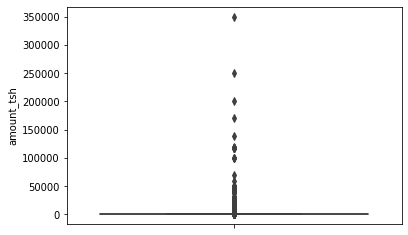

In [8]:
sns.boxplot(data=df, y='amount_tsh')

<AxesSubplot:ylabel='gps_height'>

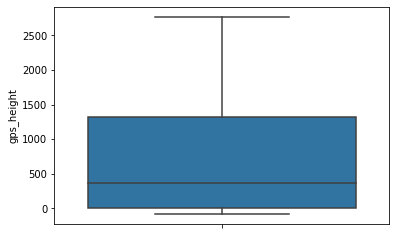

In [7]:
sns.boxplot(data=df, y='gps_height')

<AxesSubplot:ylabel='population'>

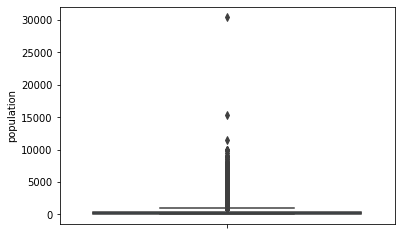

In [55]:
sns.boxplot(data=df, y='population')

Based off these 3, only gps_height is safe to directly normalise. For both population and amount_tsh, we may have to remove the outliers.

Let's impute the missing population data.

In [53]:
df['population'] = df['population'].replace(0, np.nan)

df['population'] = df['population'].fillna(df.groupby(['region', 'lga', 'ward'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby(['region', 'lga'])['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('region')['population'].transform('mean'))
df['population'] = df['population'].fillna(df.groupby('basin')['population'].transform('mean'))

In [58]:
df['population'].describe()

count    59400.000000
mean       331.659846
std        480.214267
min          1.000000
25%        100.000000
50%        250.000000
75%        435.301386
max      30500.000000
Name: population, dtype: float64

In [11]:
def minmax_normalisation(df, col):
    df[col + "_minmaxnormalised"] = ((df[col] - df[col].min()) / (df[col].max() / df[col].min()))
    return df

In [12]:
def zscore_normalisation(df, col):
    df[col + "_zscorenormalise"] = ((df[col] - df[col].mean()) / df[col].std())
    return df